In [114]:
# AIT 526-001
# 03/26/2025
# Team 2: Yasser Jahgoori, Andrej Paskalov, Yaseen Trombati


In [116]:
# imports...
import spacy
import en_core_web_sm
from spacy import displacy
from collections import Counter

import re
import sys
import random

import bs4 as bs
import re
import nltk
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.corpus import opinion_lexicon
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer

#ML imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB

import torch
import os
import multiprocessing

In [118]:
nlp = spacy.load("en_core_web_sm")

#nltk.download('punkt')
#nltk.download('punkt_tab')

# negative words list
#nltk.download("opinion_lexicon")
negative_words = set(opinion_lexicon.negative())

# load dataset
df = pd.read_excel('dataset_filepath')
#df = pd.read_excel('/complaints_cleaned.xlsx')

# list columns
print(df.columns.tolist())

# Get the Complaint ID, Consumer complaint narrative
#subset = df[['Complaint ID', 'Consumer complaint narrative']].sample(n=100) # dataset is large, so a limit was placed
subset = df[['Complaint ID', 'Consumer complaint narrative']] # dataset is large, so a limit was placed

#subset = df[['Complaint ID', 'Consumer complaint narrative']].head(5).values # first five samples
#print(df[['Complaint ID', 'Consumer complaint narrative']].head(5))

['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue', 'Consumer complaint narrative', 'Company public response', 'Company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?', 'Submitted via', 'Date sent to company', 'Company response to consumer', 'Timely response?', 'Consumer disputed?', 'Complaint ID']


In [119]:
# Removes Duplicate Consumer Complaints
print(f"Original Subset: {len(subset)}")
subset_unique = subset.drop_duplicates(subset='Consumer complaint narrative', keep='first')
print(f"Unique Complaints: {len(subset_unique)}")
print(f"Removed {len(subset) - len(subset_unique)} duplicates")

Original Subset: 142279
Unique Complaints: 89648
Removed 52631 duplicates


In [120]:
# Get Samples to reduce runtime
subset_unique = subset_unique.sample(n=10000)

In [121]:
# Clean and tokenize complaints and score by negative frequency and weighted negative frequency (for both stemmed and unstemmed)

In [122]:
# process data
"""
PK: 'Complaint ID'
For each 'Consumer complaint narrative':
 - remove all special characters and stopwords
 - word tokenization
"""

complaint_id = subset_unique.iloc[:, 0]

# Define the negating stopwords you want to preserve
negating_stopwords = {
    "not", "no", "never", "none", "nobody", "nowhere", "nothing",
    "neither", "nor", "n't", "cannot", "hardly", "scarcely", "barely", "without"
}

# Make sure spaCy does NOT treat these words as stopwords
for word in negating_stopwords:
    nlp.vocab[word].is_stop = False

# Stemmer
stemmer = nltk.PorterStemmer()

# Clean the text
def clean_text(text):
    #cleaned = re.sub(r"[^a-zA-Z0-9\s]", "", text) # remove special characters and punctuation
    cleaned = re.sub(r"[^a-zA-Z0-9\s\.!?]", "", text) # remove special characters and punctuation (except .!?)
    cleaned = re.sub(r"\s+", " ", cleaned).strip() # remove extra spaces

    doc = nlp(cleaned)

    word_tokens = [x.orth_ for x in doc if not x.is_stop] # remove stopwords
    sent_tokens = [sent.text.strip() for sent in doc.sents if sent.text.strip()]

    word_tokens_stem = [stemmer.stem(token.orth_) for token in doc if not token.is_stop]

    sent_tokens_stem = []
    for sent in doc.sents:
        stripped = sent.text.strip()
        if stripped:
            sent_doc = nlp(stripped)
            stemmed_sent = " ".join(stemmer.stem(token.text) for token in sent_doc if not token.is_punct)
            sent_tokens_stem.append(stemmed_sent)

    return word_tokens, sent_tokens, word_tokens_stem, sent_tokens_stem

# Calculate the Score
def calculate(word_tokens, sent_tokens):
    #negative_found = [word for word in word_tokens if word in negative_words] # find negative words in the complaint
    #print(f"Negative Word Count: {len(negative_found)} | Word Count: {len(word_tokens)} | Negative Words Found: {negative_found}")

    # Negative Word Frequency
    negative_count = len([word for word in word_tokens if word in negative_words]) # count negative words
    neg_word_score = negative_count / len(word_tokens) * 100 # Negative Word Ratio: (Negative Words / Total Words) * 100

    # Weighted Negative Frequncy Scoring
    sent_scores = []
    for sent in sent_tokens:
      doc = nlp(sent)

      # Get words in sent
      words = [token.text.lower() for token in doc if not token.is_punct and not token.is_space]

      # Count negative words of sent
      neg_count = sum(1 for word in words if word in negative_words)

      # Prevent zero denominator
      if len(words) > 0:
          neg_ratio = neg_count / len(words) * 100
      else:
          neg_ratio = 0

      sent_scores.append(neg_ratio)

    avg_sent_score = sum(sent_scores) / len(sent_scores) if sent_scores else 0

    return round(neg_word_score, 2), round(avg_sent_score, 2)

In [123]:
# Get the polarity score using TextBlob

In [124]:
def polarity_score(text):
  # Create a TextBlob object from the full text
  blob = TextBlob(text)

  # Analyze each word's sentiment individually (ignoring positive polarity words)
  negative_polarities = []
  for word in blob.words:
      word_blob = TextBlob(word)
      polarity = word_blob.sentiment.polarity
      if polarity <= 0:
          negative_polarities.append(polarity)

  # Compute average polarity of only negative or neutral words
  if negative_polarities:
      avg_negative_polarity = sum(negative_polarities) / len(negative_polarities)
  else:
      avg_negative_polarity = 0.0

  return avg_negative_polarity

In [125]:
# Getting the polarity score using the FinBERT deep learning model

In [126]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

In [127]:
model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
finbert_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

def get_finbert_polarity(text, word_limit=500):
    if not isinstance(text, str) or text.strip() == "":
        return None

    # Step 1: Split into sentences
    sentences = sent_tokenize(text)

    # Step 2: Chunk sentences based on word count
    sent_chunk = []
    chunk_word_count = 0
    chunks = []

    for sentence in sentences:
        words_in_sentence = len(sentence.split())

        if chunk_word_count + words_in_sentence > word_limit:
            if sent_chunk:
                chunks.append(' '.join(sent_chunk))
            sent_chunk = []
            chunk_word_count = 0

        sent_chunk.append(sentence)
        chunk_word_count += words_in_sentence

    if sent_chunk:
        chunks.append(' '.join(sent_chunk))

    # Step 3: Process each chunk
    polarity_scores = []
    for chunk in chunks:
        result = finbert_pipeline(chunk, truncation=True)[0]
        label = result['label'].lower()
        score = result['score']  # get model confidence between 0 and 1

        if label == "negative":
            polarity_scores.append(-score)  # negative confidence
        else:
            polarity_scores.append(0.0)     # neutral or positive treated as 0

    # Step 4: Average polarity across all chunks
    avg_polarity = sum(polarity_scores) / len(polarity_scores)

    return round(avg_polarity, 5)  # keep 5 decimal places

Device set to use cpu


In [128]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm.notebook import tqdm

# Function to process each row
def process_row(row):
    complaint_id = row['Complaint ID']
    complaint = row['Consumer complaint narrative']

    # Text Processing: Word & Sent tokenization (Non-stemmed & Stemmed)
    word_tokens, sent_tokens, word_tokens_stem, sent_tokens_stem = clean_text(complaint)

    # Scoring
    neg_word_ratio, neg_sent_ratio = calculate(word_tokens, sent_tokens)
    neg_word_ratio_stem, neg_sent_ratio_stem = calculate(word_tokens_stem, sent_tokens_stem)
    avg_pol = polarity_score(complaint)
    fin_pol = get_finbert_polarity(complaint, 500)

    return (complaint_id, neg_word_ratio, neg_sent_ratio, neg_word_ratio_stem, neg_sent_ratio_stem, avg_pol, fin_pol)


In [129]:
from tqdm.notebook import tqdm


In [130]:
from tqdm import tqdm

negative_scores = []
rows = list(subset_unique.iterrows())
with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
    futures = [executor.submit(process_row, row[1]) for row in rows]  # row[1] is the Series

    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing complaints"):
        try:
            result = future.result(timeout=30)  # adjust timeout as needed
            negative_scores.append(result)
        except TimeoutError:
            print("A thread took too long and was skipped.")
            negative_scores.append(None)

Processing complaints: 100%|██████████| 10000/10000 [57:10<00:00,  2.91it/s] 


In [144]:
"""
from tqdm import tqdm

negative_scores = []

for i, row in tqdm(subset_unique.iterrows(), total=len(subset_unique), desc="Processing complaints"):
    complaint_id = row['Complaint ID']
    complaint = row['Consumer complaint narrative']

    word_tokens, sent_tokens, word_tokens_stem, sent_tokens_stem = clean_text(complaint)
    neg_word_ratio, neg_sent_ratio = calculate(word_tokens, sent_tokens)
    neg_word_ratio_stem, neg_sent_ratio_stem = calculate(word_tokens_stem, sent_tokens_stem)
    avg_pol = polarity_score(complaint)
    fin_pol = get_finbert_polarity(complaint, 500)

    negative_scores.append((complaint_id, neg_word_ratio, neg_sent_ratio,
                            neg_word_ratio_stem, neg_sent_ratio_stem, avg_pol, fin_pol)) """

'\nfrom tqdm import tqdm\n\nnegative_scores = []\n\nfor i, row in tqdm(subset_unique.iterrows(), total=len(subset_unique), desc="Processing complaints"):\n    complaint_id = row[\'Complaint ID\']\n    complaint = row[\'Consumer complaint narrative\']\n\n    word_tokens, sent_tokens, word_tokens_stem, sent_tokens_stem = clean_text(complaint)\n    neg_word_ratio, neg_sent_ratio = calculate(word_tokens, sent_tokens)\n    neg_word_ratio_stem, neg_sent_ratio_stem = calculate(word_tokens_stem, sent_tokens_stem)\n    avg_pol = polarity_score(complaint)\n    fin_pol = get_finbert_polarity(complaint, 500)\n\n    negative_scores.append((complaint_id, neg_word_ratio, neg_sent_ratio,\n                            neg_word_ratio_stem, neg_sent_ratio_stem, avg_pol, fin_pol)) '

In [145]:
# Print using tabulate

In [146]:
from tabulate import tabulate

# Header for the table
headers = [
    "Complaint ID",
    "Neg Freq (Non-stemmed)",
    "Wgt Neg Freq (Non-stemmed)",
    "Neg Freq (Stemmed)",
    "Wgt Neg Freq (Stemmed)",
    "Avg Polarity",
    "Finbert Polarity"
]

# Format data into rows
table_data = []
for id, neg_word_ratio, neg_sent_ratio, neg_word_ratio_stem, neg_sent_ratio_stem, avg_pol, fin_pol in negative_scores:
    row = [
        id,
        f"{neg_word_ratio:.2f}%",
        f"{neg_sent_ratio:.2f}%",
        f"{neg_word_ratio_stem:.2f}%",
        f"{neg_sent_ratio_stem:.2f}%",
        f"{avg_pol:.3f}",
        f"{fin_pol:.3f}"
    ]
    table_data.append(row)

# Print the table
print(tabulate(table_data[:100], headers=headers, tablefmt="pretty"))

+--------------+------------------------+----------------------------+--------------------+------------------------+--------------+------------------+
| Complaint ID | Neg Freq (Non-stemmed) | Wgt Neg Freq (Non-stemmed) | Neg Freq (Stemmed) | Wgt Neg Freq (Stemmed) | Avg Polarity | Finbert Polarity |
+--------------+------------------------+----------------------------+--------------------+------------------------+--------------+------------------+
|   12089744   |         0.00%          |           0.00%            |       0.00%        |         0.00%          |    -0.019    |      0.000       |
|   10821128   |         0.00%          |           0.00%            |       0.00%        |         0.00%          |    -0.018    |      0.000       |
|   8368693    |         2.78%          |           2.22%            |       0.00%        |         0.00%          |    0.000     |      0.000       |
|   11471832   |         4.35%          |           1.45%            |       0.00%        |   

In [147]:
# Calculate Percentile for all scores

# Calculate average percentile for all features per sample

# Label each complaint using average percentile

# Neutral (0), Slightly Negative (1-25), Moderately Negative (26-50), Very Negative (51-75), Extremely Negative (76-100)

In [148]:
#Convert to DataFrame for percentile labeling
df_scores = pd.DataFrame(negative_scores, columns=[
    "Complaint ID", "NegFreq", "WgtNegFreq", "NegFreqStem", "WgtNegFreqStem", "AvgPolarity", "FinbertPolarity"
])

# Calculate percentiles safely for each column
score_columns = ["NegFreq", "WgtNegFreq", "NegFreqStem", "WgtNegFreqStem", "AvgPolarity", "FinbertPolarity"]
for col in score_columns:
    df_scores[col] = pd.to_numeric(df_scores[col], errors='coerce')
    df_scores[col + "_pct"] = df_scores[col].rank(pct=True, na_option='bottom') * 100

# Compute average percentile per complaint
pct_columns = [col + "_pct" for col in score_columns]
df_scores["AvgPercentile"] = df_scores[pct_columns].mean(axis=1)

# Label each complaint based on average percentile
def assign_label(percentile):
    if percentile == 0:
        return "Neutral"
    elif percentile <= 25:
        return "Slightly Negative"
    elif percentile <= 50:
        return "Moderately Negative"
    elif percentile <= 75:
        return "Very Negative"
    else:
        return "Extremely Negative"

df_scores["NegativityLabel"] = df_scores["AvgPercentile"].apply(assign_label)

# Print labeled data
print(df_scores[["Complaint ID", "AvgPercentile", "NegativityLabel"]].head())


   Complaint ID  AvgPercentile      NegativityLabel
0      12089744        17.5800    Slightly Negative
1      10821128        17.6125    Slightly Negative
2       8368693        42.0025  Moderately Negative
3      11471832        42.5850  Moderately Negative
4      11258348        56.6250        Very Negative


In [149]:
# Use negative_scores for Clustering (KNN)
# Use labels for Naive Bayes

In [280]:
# Enocde labels for ML
le = LabelEncoder()
df_scores["LabelEncoded"] = le.fit_transform(df_scores["NegativityLabel"])
# Split dataset for ML
X = df_scores[pct_columns]
y = df_scores["LabelEncoded"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
labels = list(range(len(le.classes_)))
print("\nKNN Classification Report:")
print(classification_report(y_test, y_pred_knn, labels=labels, target_names=le.classes_))

# Decision Tree Classifier
tree = DecisionTreeClassifier(max_depth=4, min_samples_leaf = 3,random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
print("\nDecision Tree Classification Report:")
print(classification_report(y_test, y_pred_tree, labels=labels, target_names=le.classes_))


KNN Classification Report:
                     precision    recall  f1-score   support

 Extremely Negative       0.93      0.89      0.91        99
Moderately Negative       0.97      0.97      0.97      1004
  Slightly Negative       0.98      0.92      0.95        61
      Very Negative       0.95      0.96      0.96       836

           accuracy                           0.96      2000
          macro avg       0.96      0.94      0.95      2000
       weighted avg       0.96      0.96      0.96      2000


Decision Tree Classification Report:
                     precision    recall  f1-score   support

 Extremely Negative       0.83      0.45      0.59        99
Moderately Negative       0.82      0.89      0.85      1004
  Slightly Negative       1.00      0.15      0.26        61
      Very Negative       0.80      0.82      0.81       836

           accuracy                           0.82      2000
          macro avg       0.87      0.58      0.63      2000
       weighte

In [284]:
print (le.classes_)

['Extremely Negative' 'Moderately Negative' 'Slightly Negative'
 'Very Negative']


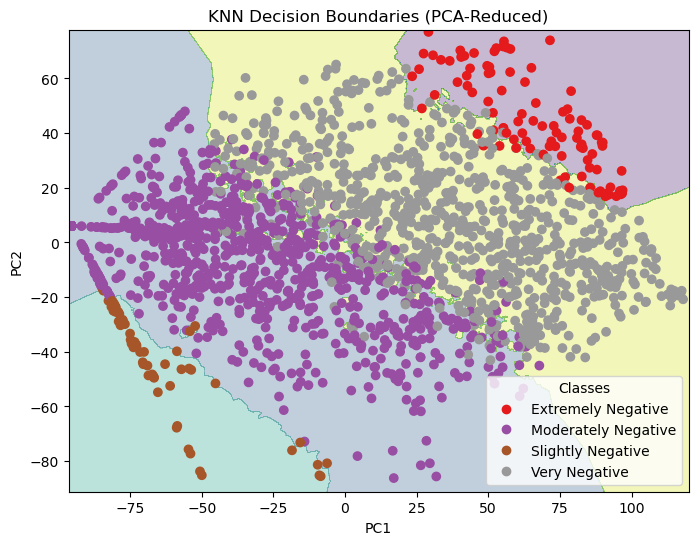

In [312]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train)
X_test_2d = pca.transform(X_test)

# Refit KNN on reduced data
knn_2d = KNeighborsClassifier(n_neighbors=5)
knn_2d.fit(X_train_2d, y_train)

# Meshgrid for plotting decision boundaries
x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
Z = knn_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plotting
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3)
scatter = plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=y_test, cmap=plt.cm.Set1)
plt.title("KNN Decision Boundaries (PCA-Reduced)")
plt.xlabel("PC1")
plt.ylabel("PC2")

custom_labels = ['Extremely Negative', 'Moderately Negative', 'Slightly Negative', "Very Negative"]
plt.legend(handles=scatter.legend_elements()[0], labels=custom_labels, title="Classes")
plt.show()


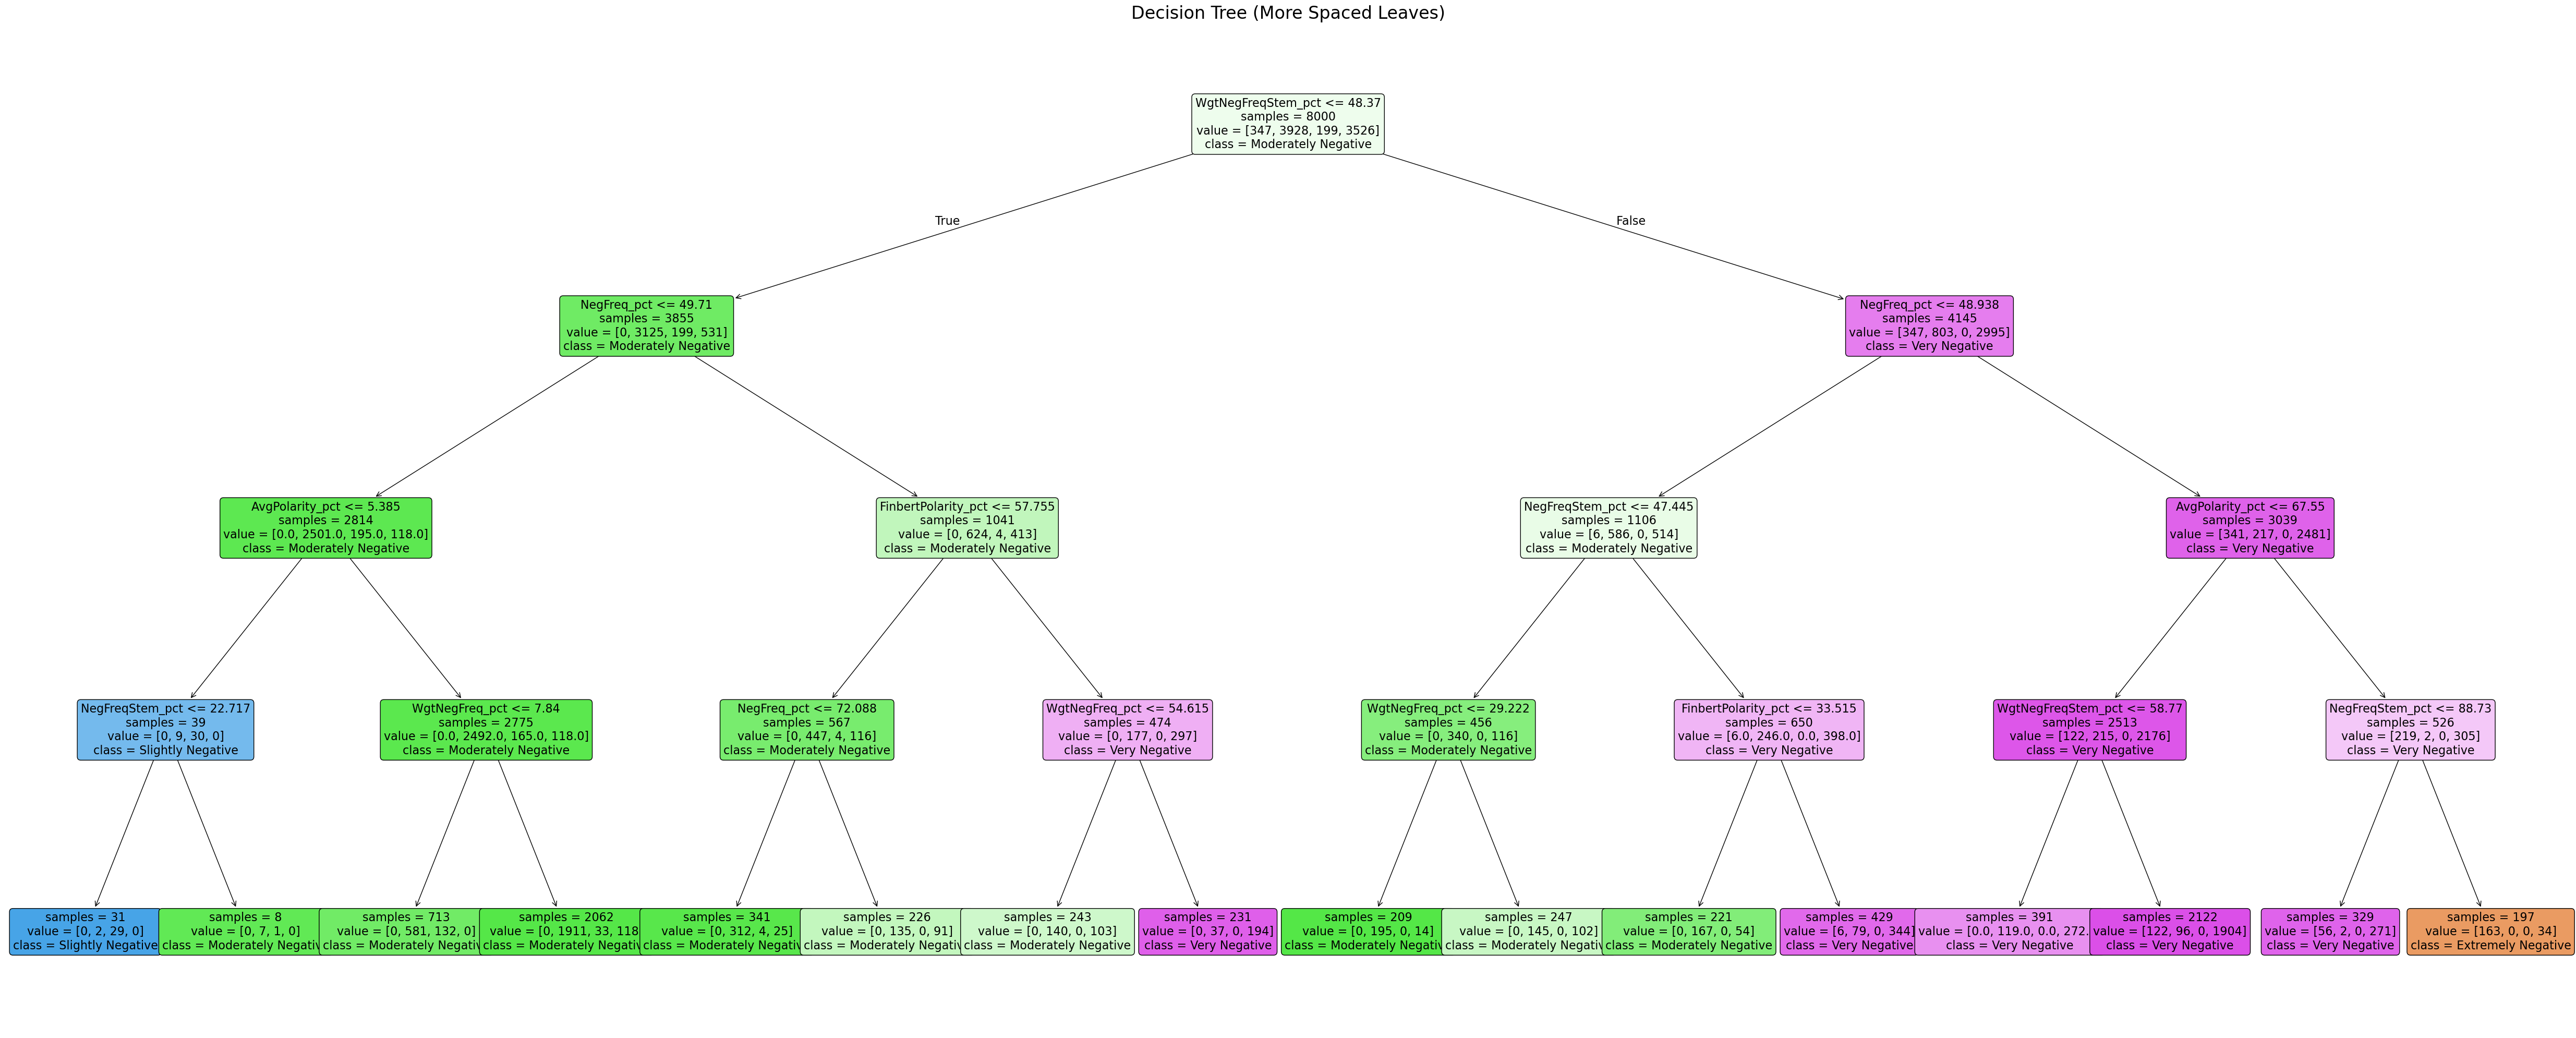

In [238]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
plt.figure(figsize=(50, 20))  # Wider canvas = more horizontal space for leaves
plot_tree(tree, 
          feature_names=X_train.columns,
          class_names=le.classes_,
          filled=True,
          rounded=True,
          fontsize=16,
          impurity=False)
plt.title("Decision Tree (More Spaced Leaves)", fontsize=24)
plt.tight_layout()
plt.show()



In [282]:
# References:

# [1] Bird, S., & Loper, E. (n.d.). The NLTK corpus reader. Natural Language Toolkit. Retrieved March 31, 2025, from https://www.nltk.org/howto/corpus.html